## Load libraries

In [1]:
# pip install scikit-learn==1.2.2
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.datasets import make_classification
from sklearn import svm
from numba import njit, prange, jit
import sklearn
import imblearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import scipy.stats as ss
import sys
mod = sys.modules[__name__]
import inspect
import glob
import os
from time import perf_counter
import matplotlib.pyplot as plt
from IPython.display import display, HTML

## Methods

In [2]:
@njit(parallel=True, fastmath=True)
def euclidean_distance(A, B):
    n_A, n_B = A.shape[0], B.shape[0]
    n_feat = B.shape[1]
    
    dist = np.empty(shape=(n_A, n_B), dtype=A.dtype)

    for i0 in prange(n_A):
        for i1 in prange(n_B):
            val = 0.
            for i2 in prange(n_feat):
                temp = A[i0, i2] - B[i1, i2]
                val += temp * temp
            dist[i0, i1] = val ** 0.5

    return dist

def PSU(aa, bb):
    maj_where = np.where(bb == 0)[0]
    min_where = np.where(bb == 1)[0]

    maj_data = aa[maj_where, ]
    min_data = aa[min_where, ]

    n_maj = len(maj_where)
    n_min = len(min_where)

    temp_interval = np.array_split(np.arange(n_maj), n_min)

    maj_sort = maj_where[np.argsort(euclidean_distance(np.array([np.mean(maj_data, axis = 0)]), maj_data)[0])]
    temp_cent = [maj_sort[temp_interval[0]][-1]]

    for i in prange(n_min - 1):
        temp_data = aa[temp_cent, ]
        temp_cent.append(maj_sort[temp_interval[i + 1]][np.argmax(np.sum(euclidean_distance(temp_data, aa[maj_sort[temp_interval[i + 1]]]), axis=0))])

    return np.vstack((aa[temp_cent, ], min_data)), np.hstack((np.zeros(n_min), np.ones(n_min)))

def PSUm(aa, bb):
    
    maj_where = np.where(bb==0)[0]
    min_where = np.where(bb==1)[0]
    
    maj_data = aa[maj_where,]
    min_data = aa[min_where,]
    
    temp_sort = euclidean_distance(maj_data, min_data).min(axis=1).argsort()[::-1]
    
    n_min = len(min_where)
    
    temp_interval = np.array_split(np.arange(len(temp_sort)), n_min)

    maj_re_data_index = [temp_sort[temp_interval[0]][-1]]
    
    for i0 in range(n_min -1):
        
        maj_re_data_index.append(temp_sort[temp_interval[i0+1]][euclidean_distance(maj_data[maj_re_data_index,:], maj_data[temp_sort[temp_interval[i0+1]],:]).min(axis = 0).argmax()])
    
    return [np.vstack((maj_data[maj_re_data_index], min_data)), np.hstack((np.zeros(n_min), np.ones(n_min)))]


def PSUmm(aa, bb):
    
    maj_where = np.where(bb==0)[0]
    min_where = np.where(bb==1)[0]
    
    maj_data = aa[maj_where,]
    min_data = aa[min_where,]
    
    n_partition = int(len(min_where) ** 0.5)
    
    n_min = len(min_where)
    
    temp_interval = np.array_split(np.arange(len(maj_where)), n_partition)
    temp_interval2 = np.array_split(np.arange(len(min_where)), n_partition)

    
    maj_re_data_index = []
    
    for i0 in range(n_partition):
        
        temp_sort = euclidean_distance(maj_data[temp_interval[i0]], min_data).min(axis = 1).argsort()[::-1]
        
        temp_interval3 = np.array_split(temp_interval[i0][temp_sort], len(temp_interval2[i0]))
        for i1 in range(len(temp_interval2[i0])):
            
            if i0 == 0 and i1 == 0:
                maj_re_data_index = [temp_interval3[0][-1]]
                
            else:
                maj_re_data_index.append(temp_interval3[i1][euclidean_distance(maj_data[maj_re_data_index], maj_data[temp_interval3[i1]]).min(axis = 0).argmax()])
                
        
    return [np.vstack((maj_data[maj_re_data_index], min_data)), np.hstack((np.zeros(n_min), np.ones(n_min)))]

## Figure-1

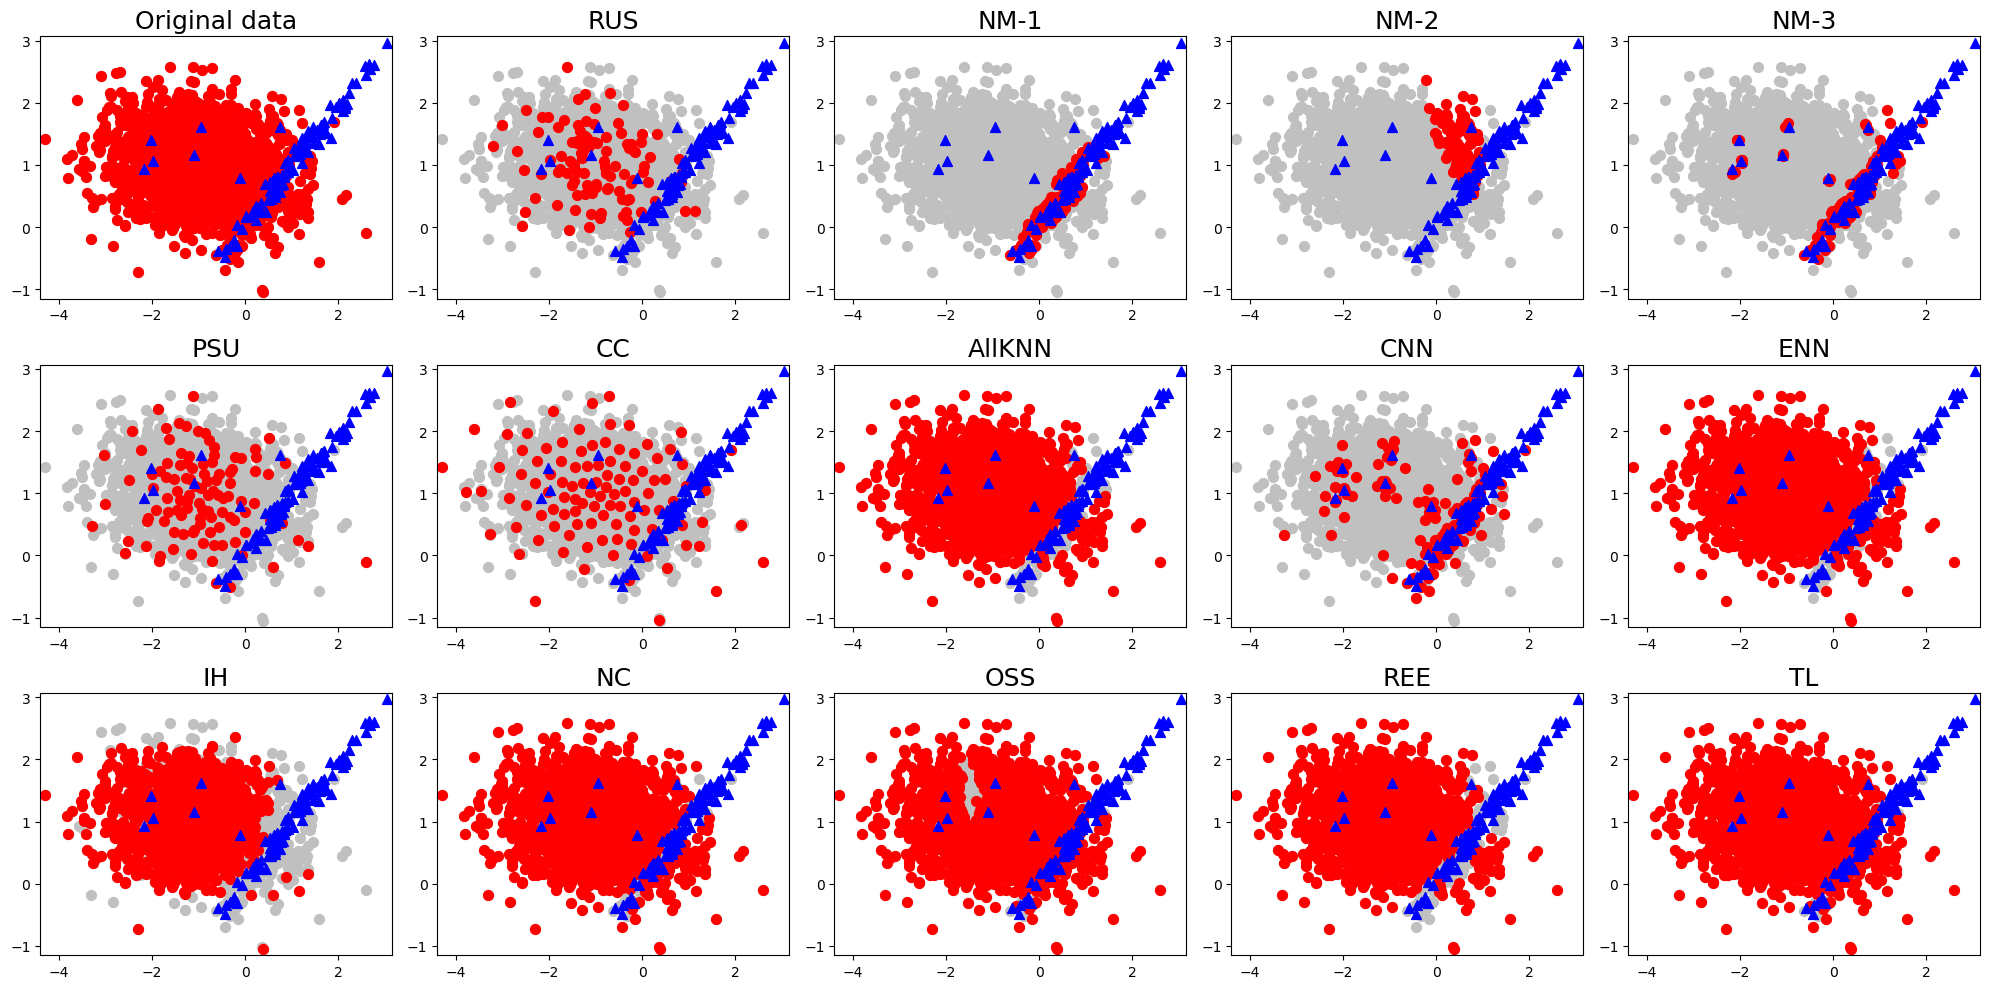

In [3]:
from matplotlib.ticker import MaxNLocator

dataset, labels = make_classification(n_samples=2000, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       weights=[0.95, 0.05], class_sep=1.0,
                                       random_state=42)


methods = ["RUS", "NM-1", "NM-2", "NM-3", "PSU", "PSU-m", "CC", 
           "ALLKNN", "CNN", "ENN", "IH", "NC", "OSS", "REE", "TL"]


def resampling(X, y, method, seed):
    if method == "RUS":
        return imblearn.under_sampling.RandomUnderSampler(random_state = seed).fit_resample(X, y)
    if method == "NM-1":
        return imblearn.under_sampling.NearMiss(version = 1).fit_resample(X, y)
    if method == "NM-2":
        return imblearn.under_sampling.NearMiss(version = 2).fit_resample(X, y)
    if method == "NM-3":
        return imblearn.under_sampling.NearMiss(version = 3).fit_resample(X, y)
    if method == "PSU":
        return PSU(X, y)
    if method == "PSU-m":
        return PSUm(X, y)
    if method == "PSU-mm":
        return PSUmm(X, y)
    if method == "CC":
        return imblearn.under_sampling.ClusterCentroids(random_state = seed).fit_resample(X, y)
    if method == "AllKNN":
        return imblearn.under_sampling.AllKNN().fit_resample(X, y)
    if method == "CNN":
        return imblearn.under_sampling.CondensedNearestNeighbour().fit_resample(X, y)
    if method == "ENN":
        return imblearn.under_sampling.EditedNearestNeighbours().fit_resample(X, y)
    if method == "IH":
        return imblearn.under_sampling.InstanceHardnessThreshold().fit_resample(X, y)
    if method == "NC":
        return imblearn.under_sampling.NeighbourhoodCleaningRule().fit_resample(X, y)
    if method == "OSS":
        return imblearn.under_sampling.OneSidedSelection().fit_resample(X, y)
    if method == "REE":
        return imblearn.under_sampling.RepeatedEditedNearestNeighbours().fit_resample(X, y)
    if method == "TL":
        return imblearn.under_sampling.TomekLinks().fit_resample(X, y)
    
fig, axs = plt.subplots(3, 5, figsize = (20, 10))

locations = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
             (1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
             (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]

ss = 50

for i0, method in enumerate(["Original data", "RUS", "NM-1", "NM-2", "NM-3", "PSU", 
                             "CC", "AllKNN", "CNN", "ENN", "IH", "NC", "OSS", "REE", "TL"]):
    
    if method == "Original data":
        re_data, re_label = dataset, labels
    else:
        re_data, re_label = resampling(dataset, labels, method, 0)
    
    axs[locations[i0]].set_title(str(method), fontsize = 18)
    gap = 0.1
    axs[locations[i0]].set_xlim(dataset[:,0].min() - gap, dataset[:,0].max() + gap)
    axs[locations[i0]].set_ylim(dataset[:,1].min() - gap, dataset[:,1].max() + gap)
    
    axs[locations[i0]].xaxis.set_major_locator(MaxNLocator(5))
    axs[locations[i0]].yaxis.set_major_locator(MaxNLocator(5))
    
    axs[locations[i0]].scatter(dataset[labels == 0, 0],
                               dataset[labels == 0, 1],
                               color = "silver",
                               s = ss)
    
    axs[locations[i0]].scatter(re_data[re_label == 0, 0], 
                               re_data[re_label == 0, 1],
                               color = "red",
                               marker = "o",
                               s = ss)

    axs[locations[i0]].scatter(re_data[re_label == 1, 0], 
                               re_data[re_label == 1, 1],
                               color = "blue", 
                               marker = "^",
                               s = ss)
    
plt.tight_layout()
plt.show()

## Figure-2

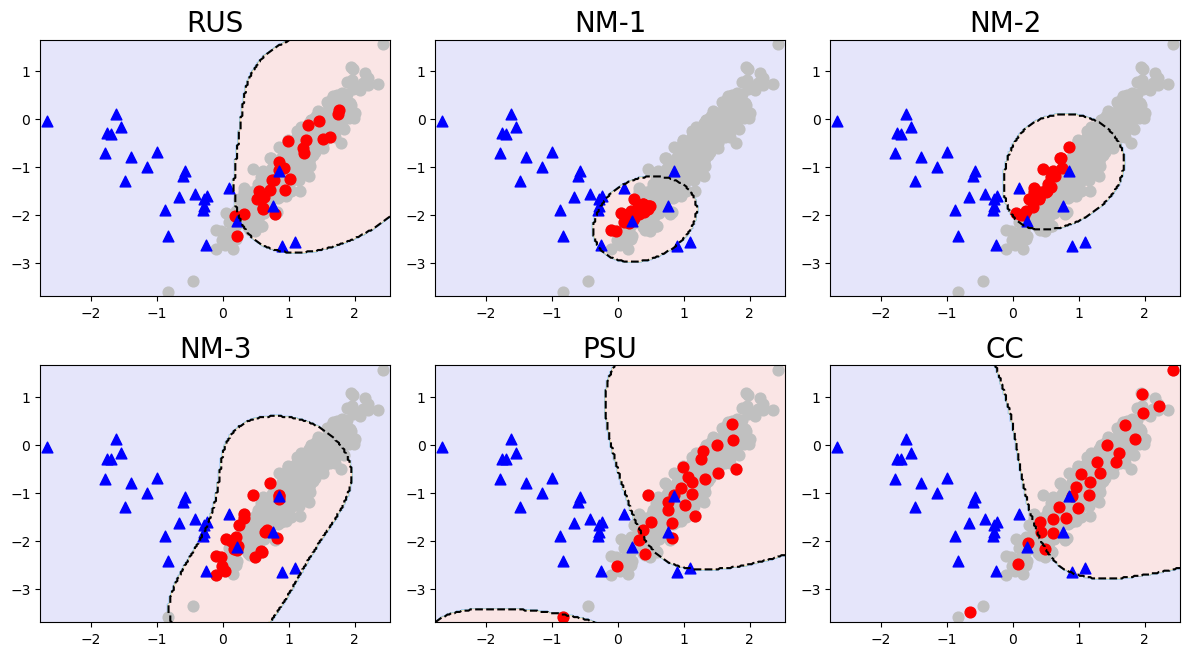

In [4]:
dataset, labels = make_classification(n_samples=500, n_features=2, n_informative=2,
                                           n_redundant=0, n_clusters_per_class=1,
                                           weights=[0.95, 0.05], class_sep = 1,
                                           random_state=1915)


fig, axs = plt.subplots(2, 3, figsize = (20/5*3, 10/3*2))

locations = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

ss = 60

for i0, method in enumerate(["RUS", "NM-1", "NM-2", "NM-3", "PSU", "CC"]):
    
    gap = 0.1
    
    xmax, xmin = np.max(dataset[:,0]) + gap, np.min(dataset[:,0]) - gap
    ymax, ymin = np.max(dataset[:,1]) + gap, np.min(dataset[:,1]) - gap
    
    if method == "Original data":
        re_data, re_label = dataset, labels
    else:
        re_data, re_label = resampling(dataset, labels, method, 0)
    
    
    model = svm.SVC(kernel = "rbf")
    model.fit(re_data, re_label)
    
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axs[locations[i0]].contourf(xx, yy, Z, cmap=plt.cm.jet_r, alpha=0.1)
    axs[locations[i0]].contour(xx, yy, Z, levels=[0], colors='black',linestyles='dashed')

    
    axs[locations[i0]].set_xlim(dataset[:,0].min() - gap, dataset[:,0].max() + gap)
    axs[locations[i0]].set_ylim(dataset[:,1].min() - gap, dataset[:,1].max() + gap)
    
    axs[locations[i0]].set_title(str(method), fontsize = 20)
    
    axs[locations[i0]].scatter(dataset[labels == 0, 0],
                               dataset[labels == 0, 1],
                               color = "silver",
                               s = ss)
    
    axs[locations[i0]].scatter(re_data[re_label == 0, 0], 
                               re_data[re_label == 0, 1],
                               color = "red",
                               marker = "o",
                               s = ss)

    axs[locations[i0]].scatter(re_data[re_label == 1, 0], 
                               re_data[re_label == 1, 1],
                               color = "blue", 
                               marker = "^",
                               s = ss)

plt.tight_layout()
plt.show()

## Figure-3

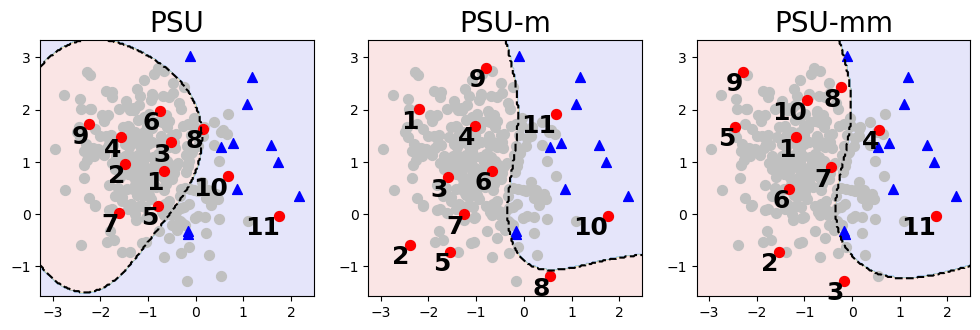

In [5]:
dataset, labels = make_classification(n_samples=300, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       weights=[0.97, 0.03], class_sep=1.0,
                                       random_state=11)


fig, axs = plt.subplots(1, 3, figsize=(12, 3.33))

locations = [0, 1, 2]

ss = 50

title_fontsize = 20

for i0 in range(3):

    if i0 == 0:
        axs[locations[i0]].set_title("PSU", fontsize = title_fontsize)
        re_data, re_label = PSU(dataset, labels)

    if i0 == 1:
        axs[locations[i0]].set_title("PSU-m", fontsize = title_fontsize)
        re_data, re_label = PSUm(dataset, labels)
        
    if i0 == 2:
        axs[locations[i0]].set_title("PSU-mm", fontsize = title_fontsize)
        re_data, re_label = PSUmm(dataset, labels)

    re_data_major = re_data[re_label == 0]
    re_data_minor = re_data[re_label == 1]

    
    gap = 0.3
    
    xmax, xmin = np.max(dataset[:,0]) + gap, np.min(dataset[:,0]) - gap
    ymax, ymin = np.max(dataset[:,1]) + gap, np.min(dataset[:,1]) - gap
     
    model = svm.SVC(kernel = "rbf")
    model.fit(re_data, re_label)
    
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[locations[i0]].contourf(xx, yy, Z, cmap=plt.cm.jet_r, alpha=0.1)
    axs[locations[i0]].contour(xx, yy, Z, levels=[0], colors='black',linestyles='dashed')
    
    axs[locations[i0]].set_xlim(dataset[:, 0].min() - gap, dataset[:, 0].max() + gap)
    axs[locations[i0]].set_ylim(dataset[:, 1].min() - gap, dataset[:, 1].max() + gap)

    axs[locations[i0]].scatter(dataset[labels == 0, 0], dataset[labels == 0, 1], color="silver", s=ss)
    axs[locations[i0]].scatter(dataset[labels == 1, 0], dataset[labels == 1, 1], color="blue", s=ss, marker = "^")

    for i1 in range(len(re_data_major)):
        axs[locations[i0]].scatter(re_data_major[i1, 0], re_data_major[i1, 1], color="red", marker="o", s = ss)
        axs[locations[i0]].text(re_data_major[i1, 0],  
                                re_data_major[i1, 1],  
                                str(i1 + 1),          
                                fontsize=18,
                                fontweight='bold',
                                horizontalalignment='right',
                                verticalalignment='top',
                                zorder=5)

plt.show()

## Figure-4

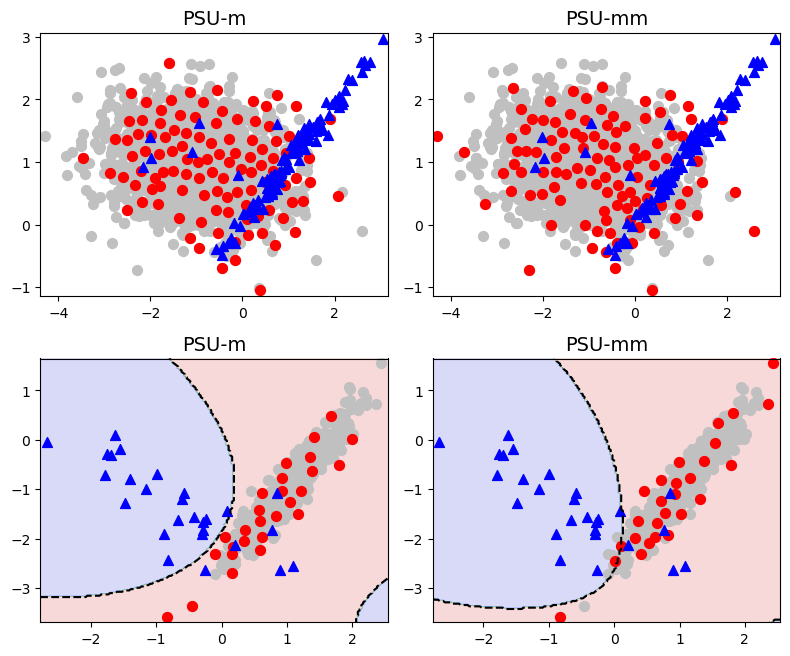

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import make_classification
from sklearn import svm


X_big, y_big = make_classification(n_samples=2000, n_features=2, n_informative=2,
                                   n_redundant=0, n_clusters_per_class=1,
                                   weights=[0.95, 0.05], class_sep=1.0,
                                   random_state=42)

X_small, y_small = make_classification(n_samples=500, n_features=2, n_informative=2,
                                       n_redundant=0, n_clusters_per_class=1,
                                       weights=[0.95, 0.05], class_sep=1.0,
                                       random_state=1915)

fig, axs = plt.subplots(2, 2, figsize = (20/5*2, 10/3*2))

axs = axs.flatten()                
methods = ["PSU-m", "PSU-mm"]      
ss   = 50
gap  = 0.1


for i, method in enumerate(methods):
    Xr, yr = resampling(X_big, y_big, method, seed=0)

    ax = axs[i]
    ax.set_title(f"{method}", fontsize=14)
    ax.set_xlim(X_big[:, 0].min() - gap, X_big[:, 0].max() + gap)
    ax.set_ylim(X_big[:, 1].min() - gap, X_big[:, 1].max() + gap)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

    ax.scatter(X_big[y_big == 0, 0], X_big[y_big == 0, 1], color="silver", s=ss)

    ax.scatter(Xr[yr == 0, 0], Xr[yr == 0, 1], color="red",  marker="o", s=ss)
    ax.scatter(Xr[yr == 1, 0], Xr[yr == 1, 1], color="blue", marker="^", s=ss)


for i, method in enumerate(methods):
    Xr, yr = resampling(X_small, y_small, method, seed=0)

    clf = svm.SVC(kernel="rbf")
    clf.fit(Xr, yr)

    ax = axs[i + 2]                       
    ax.set_title(f"{method}", fontsize=14)

    xmin, xmax = X_small[:, 0].min() - gap, X_small[:, 0].max() + gap
    ymin, ymax = X_small[:, 1].min() - gap, X_small[:, 1].max() + gap
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200),
                         np.linspace(ymin, ymax, 200))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.jet_r, alpha=0.15)
    ax.contour(xx, yy, Z, levels=[0], colors="black", linestyles="dashed")

    ax.scatter(X_small[y_small == 0, 0], X_small[y_small == 0, 1],
               color="silver", s=ss)
    ax.scatter(Xr[yr == 0, 0], Xr[yr == 0, 1], color="red",  marker="o", s=ss)
    ax.scatter(Xr[yr == 1, 0], Xr[yr == 1, 1], color="blue", marker="^", s=ss)

plt.tight_layout()
plt.show()

## Experimental results

In [14]:
methods = ["RUS", "NM-1", "NM-2", "NM-3", "PSU", "PSU-m", "PSU-mm", "CC", 
        "ALLKNN", "CNN", "ENN", "IH", "NC", "OSS", "REE", "TL"]

data_name = ['abalone-17_vs_7-8-9-10', 'abalone-19_vs_10-11-12-13', 'abalone19', 'abalone9-18', 'car-good', 'car-vgood',
             'flare-F', 'kddcup-buffer_overflow_vs_back', 'kddcup-guess_passwd_vs_satan', 'kr-vs-k-one_vs_fifteen',
             'kr-vs-k-three_vs_eleven', 'kr-vs-k-zero-one_vs_draw', 'led7digit-0-2-4-5-6-7-8-9_vs_1', 'shuttle-2_vs_5',
             'shuttle-c0-vs-c4', 'vowel0', 'winequality-red-4', 'yeast-0-2-5-6_vs_3-7-8-9', 'yeast-0-2-5-7-9_vs_3-6-8',
             'yeast-0-3-5-9_vs_7-8', 'yeast-0-5-6-7-9_vs_4', 'yeast-1-2-8-9_vs_7', 'yeast-1-4-5-8_vs_7', 'yeast-1_vs_7',
             'yeast-2_vs_4', 'yeast4', 'yeast5', 'yeast6', 
             "credit_fraud", "kddcup_(dos_vs_prb)_10%", "kddcup_(dos_vs_r2l)_10%", "record_linkage_10%", "payment_simulation_10%"]

data_name = np.array(data_name)

################################
### Load experimental results
################################
confusion_matrices = np.load(r"results\confusion_matrices.npy", allow_pickle = True)
processing_times = np.load(r"results\processing_times.npy", allow_pickle = True)
resulting_ratios = np.load(r"results\resulting_ratios.npy", allow_pickle = True)
memories = np.load(r"results\memories.npy", allow_pickle = True)

In [8]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

result_mcc = []
result_f1 = []

temp = 0
for i0 in range(33):
    for i1 in range(16):
        for i2 in range(10):
            for i3 in range(4):
                tn, fp, fn, tp = confusion_matrices[temp].ravel()
                
                if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
                    mcc = 0
                else:
                    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

                if (2 * tp + fp + fn) == 0:
                    f1 = 0
                else:
                    f1 = (2 * tp) / (2 * tp + fp + fn)

                result_mcc.append(mcc)
                result_f1.append(f1)
                
                temp += 1

reshaped_mcc = np.array(result_mcc).reshape(33, 16, 10, 4)
reshaped_f1 = np.array(result_f1).reshape(33, 16, 10, 4)

max_mcc = reshaped_mcc.max(axis=3).mean(axis=2)
max_f1 = reshaped_f1.max(axis=3).mean(axis=2)

std_mcc = reshaped_mcc.max(axis=3).std(axis=2) * 1.96 / np.sqrt(10)
std_f1 = reshaped_f1.max(axis=3).std(axis=2) * 1.96 / np.sqrt(10)

format_float = np.vectorize("{:.2f}".format)

formatted_mcc = np.core.defchararray.add(format_float(max_mcc), u"\u00B1")
formatted_mcc = np.core.defchararray.add(formatted_mcc, format_float(std_mcc))

formatted_f1 = np.core.defchararray.add(format_float(max_f1), u"\u00B1")
formatted_f1 = np.core.defchararray.add(formatted_f1, format_float(std_f1))

df_mcc = pd.DataFrame(formatted_mcc, columns=methods, index=data_name)
df_f1 = pd.DataFrame(formatted_f1, columns=methods, index=data_name)

df_combined = pd.concat({
    "MCC": df_mcc,
    "F1": df_f1}, axis=1)

def highlight_max_group(df_group):
    return df_group.style.apply(highlight_max, axis=1)

for metric in df_combined.columns.levels[0]:
    display(HTML(f"<h2>{metric} Results</h2>"))
    df_metric = df_combined[metric]
    display(df_metric.style.apply(highlight_max, axis=1))

,RUS,NM-1,NM-2,NM-3,PSU,PSU-m,PSU-mm,CC,ALLKNN,CNN,ENN,IH,NC,OSS,REE,TL
abalone-17_vs_7-8-9-10,0.29±0.03,0.09±0.02,0.02±0.03,0.19±0.06,0.26±0.04,0.30±0.05,0.32±0.05,0.32±0.05,0.42±0.12,0.37±0.15,0.40±0.12,0.44±0.09,0.43±0.14,0.38±0.14,0.44±0.13,0.41±0.15
abalone-19_vs_10-11-12-13,0.14±0.04,0.05±0.03,0.06±0.03,0.09±0.04,0.14±0.05,0.14±0.03,0.14±0.04,0.16±0.06,0.00±0.00,0.16±0.11,0.00±0.00,0.19±0.12,0.00±0.00,0.00±0.00,0.00±0.00,0.00±0.00
abalone19,0.11±0.02,0.03±0.02,0.02±0.02,0.06±0.03,0.11±0.02,0.09±0.02,0.10±0.02,0.11±0.02,0.00±0.00,0.08±0.08,0.00±0.00,0.06±0.06,0.00±0.00,0.00±0.00,0.00±0.00,0.00±0.00
abalone9-18,0.36±0.05,0.16±0.04,0.13±0.05,0.31±0.06,0.39±0.04,0.47±0.06,0.41±0.04,0.39±0.05,0.51±0.13,0.55±0.09,0.43±0.15,0.43±0.07,0.53±0.13,0.52±0.12,0.48±0.13,0.52±0.13
car-good,0.66±0.05,0.26±0.04,0.15±0.02,0.29±0.03,0.68±0.04,0.68±0.04,0.67±0.04,0.40±0.04,0.77±0.06,0.87±0.04,0.78±0.05,0.70±0.05,0.85±0.06,0.88±0.06,0.71±0.04,0.89±0.05
car-vgood,0.69±0.07,0.41±0.02,0.45±0.08,0.51±0.04,0.80±0.06,0.80±0.04,0.76±0.04,0.45±0.03,0.94±0.05,0.96±0.02,0.94±0.04,0.88±0.05,0.95±0.05,0.96±0.04,0.93±0.04,0.98±0.03
flare-F,0.37±0.03,-0.03±0.05,0.09±0.07,0.22±0.06,0.37±0.03,0.33±0.04,0.35±0.04,0.32±0.04,0.37±0.08,0.34±0.12,0.37±0.08,0.41±0.06,0.39±0.13,0.24±0.11,0.38±0.06,0.29±0.13
kddcup-buffer_overflow_vs_back,0.94±0.06,0.97±0.03,1.00±0.00,0.99±0.03,0.95±0.04,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,0.46±0.22,1.00±0.00,1.00±0.00,1.00±0.00,0.40±0.18,1.00±0.00,1.00±0.00
kddcup-guess_passwd_vs_satan,0.99±0.02,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,0.82±0.13,1.00±0.00,1.00±0.00,1.00±0.00,0.79±0.11,1.00±0.00,1.00±0.00
kr-vs-k-one_vs_fifteen,1.00±0.00,0.99±0.01,0.91±0.03,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,0.93±0.04,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00


,RUS,NM-1,NM-2,NM-3,PSU,PSU-m,PSU-mm,CC,ALLKNN,CNN,ENN,IH,NC,OSS,REE,TL
abalone-17_vs_7-8-9-10,0.20±0.02,0.07±0.01,0.05±0.00,0.14±0.04,0.19±0.03,0.24±0.05,0.25±0.05,0.25±0.04,0.40±0.12,0.35±0.14,0.39±0.11,0.42±0.08,0.41±0.14,0.35±0.13,0.42±0.12,0.39±0.14
abalone-19_vs_10-11-12-13,0.09±0.02,0.05±0.01,0.05±0.01,0.06±0.01,0.09±0.02,0.09±0.01,0.09±0.02,0.11±0.03,0.00±0.00,0.15±0.10,0.00±0.00,0.19±0.12,0.00±0.00,0.00±0.00,0.00±0.00,0.00±0.00
abalone19,0.04±0.01,0.02±0.00,0.02±0.00,0.03±0.01,0.04±0.00,0.04±0.01,0.04±0.01,0.05±0.01,0.00±0.00,0.08±0.08,0.00±0.00,0.06±0.06,0.00±0.00,0.00±0.00,0.00±0.00,0.00±0.00
abalone9-18,0.34±0.04,0.17±0.02,0.15±0.02,0.30±0.05,0.37±0.04,0.46±0.06,0.41±0.03,0.38±0.04,0.48±0.13,0.55±0.08,0.40±0.15,0.42±0.06,0.51±0.13,0.47±0.12,0.47±0.13,0.49±0.13
car-good,0.63±0.06,0.21±0.03,0.13±0.01,0.23±0.03,0.65±0.05,0.65±0.05,0.64±0.04,0.33±0.04,0.75±0.06,0.87±0.04,0.77±0.06,0.68±0.06,0.84±0.07,0.88±0.05,0.69±0.04,0.89±0.05
car-vgood,0.67±0.08,0.34±0.02,0.39±0.09,0.45±0.05,0.79±0.07,0.79±0.05,0.75±0.05,0.37±0.04,0.94±0.05,0.96±0.02,0.94±0.04,0.87±0.05,0.95±0.05,0.96±0.04,0.93±0.05,0.98±0.03
flare-F,0.30±0.02,0.07±0.01,0.11±0.03,0.21±0.04,0.31±0.02,0.29±0.03,0.30±0.04,0.28±0.03,0.38±0.07,0.33±0.10,0.39±0.07,0.38±0.06,0.37±0.11,0.23±0.10,0.38±0.05,0.27±0.12
kddcup-buffer_overflow_vs_back,0.94±0.06,0.97±0.04,1.00±0.00,0.99±0.03,0.94±0.04,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,0.40±0.24,1.00±0.00,1.00±0.00,1.00±0.00,0.34±0.20,1.00±0.00,1.00±0.00
kddcup-guess_passwd_vs_satan,0.99±0.02,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,0.80±0.15,1.00±0.00,1.00±0.00,1.00±0.00,0.77±0.13,1.00±0.00,1.00±0.00
kr-vs-k-one_vs_fifteen,1.00±0.00,0.99±0.01,0.90±0.03,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,0.93±0.04,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00,1.00±0.00


In [8]:
df_processing = pd.DataFrame(
    np.array(processing_times).reshape(33, 16, 10).mean(axis=2),
    columns=methods,
    index=data_name
).round(3)

display(HTML("<h2>Processing Times</h2>"))
display(df_processing)

df_ratios = pd.DataFrame(
    np.array(resulting_ratios).reshape(33, 16, 10).mean(axis=2) * 100,
    columns=methods,
    index=data_name
).round(2)

display(HTML("<h2>Resulting Ratios (%)</h2>"))
display(df_ratios)

,RUS,NM-1,NM-2,NM-3,PSU,PSU-m,PSU-mm,CC,ALLKNN,CNN,ENN,IH,NC,OSS,REE,TL
abalone-17_vs_7-8-9-10,0.001,0.012,0.020,0.013,0.005,0.003,0.007,0.211,0.074,4.815,0.036,1.082,0.074,0.064,0.098,0.034
abalone-19_vs_10-11-12-13,0.001,0.009,0.013,0.010,0.004,0.001,0.004,0.119,0.052,3.405,0.028,0.871,0.055,0.051,0.078,0.024
abalone19,0.002,0.016,0.021,0.015,0.005,0.003,0.007,0.206,0.126,11.382,0.061,1.261,0.124,0.104,0.224,0.048
abalone9-18,0.001,0.007,0.008,0.008,0.004,0.001,0.004,0.084,0.028,0.929,0.012,0.707,0.033,0.031,0.034,0.012
car-good,0.001,0.042,0.018,0.008,0.007,0.003,0.009,0.264,0.044,0.492,0.022,0.633,0.057,0.024,0.054,0.024
car-vgood,0.001,0.043,0.016,0.008,0.007,0.004,0.010,0.254,0.043,0.497,0.023,0.616,0.056,0.025,0.050,0.022
flare-F,0.001,0.040,0.009,0.006,0.004,0.002,0.005,0.098,0.028,0.216,0.012,0.583,0.037,0.014,0.033,0.012
kddcup-buffer_overflow_vs_back,0.002,0.042,0.011,0.008,0.005,0.009,0.008,0.154,0.075,0.612,0.034,0.601,0.068,0.009,0.035,0.033
kddcup-guess_passwd_vs_satan,0.002,0.042,0.013,0.008,0.010,0.013,0.014,0.208,0.052,0.207,0.028,0.567,0.052,0.010,0.040,0.025
kr-vs-k-one_vs_fifteen,0.002,0.045,0.022,0.009,0.007,0.014,0.012,0.210,0.063,0.078,0.032,0.603,0.063,0.010,0.031,0.030


,RUS,NM-1,NM-2,NM-3,PSU,PSU-m,PSU-mm,CC,ALLKNN,CNN,ENN,IH,NC,OSS,REE,TL
abalone-17_vs_7-8-9-10,4.96,4.96,4.96,4.96,4.96,4.96,4.96,4.96,97.17,9.32,97.44,66.12,95.90,87.48,96.95,99.42
abalone-19_vs_10-11-12-13,3.95,3.95,3.95,3.95,3.95,3.95,3.95,3.95,94.55,11.93,95.38,56.10,95.01,94.55,93.86,99.06
abalone19,1.53,1.53,1.53,1.53,1.53,1.53,1.53,1.53,97.64,5.83,97.91,76.37,97.83,92.87,97.39,99.63
abalone9-18,11.49,11.49,11.49,11.49,11.49,11.49,11.49,11.49,92.78,18.13,93.31,42.30,88.89,94.92,92.11,98.92
car-good,7.99,7.99,7.99,7.99,7.99,7.99,7.99,7.99,91.52,16.85,92.39,71.85,94.76,90.50,90.34,97.72
car-vgood,7.52,7.52,7.52,7.52,7.52,7.52,7.52,7.52,91.94,16.94,92.23,78.56,95.55,89.65,91.40,97.46
flare-F,8.07,8.07,8.07,8.07,8.07,8.07,8.07,8.07,92.60,16.64,93.67,77.04,93.87,89.12,91.16,99.54
kddcup-buffer_overflow_vs_back,2.69,2.69,2.69,2.37,2.69,2.69,2.69,2.69,100.00,1.39,100.00,98.94,99.85,1.39,100.00,100.00
kddcup-guess_passwd_vs_satan,6.46,6.46,6.46,3.88,6.46,6.46,6.46,6.46,99.94,3.36,99.94,98.77,99.97,3.36,99.94,100.00
kr-vs-k-one_vs_fifteen,6.95,6.95,6.95,6.71,6.95,6.95,6.95,6.95,100.00,3.75,100.00,96.09,100.00,10.94,100.00,100.00


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


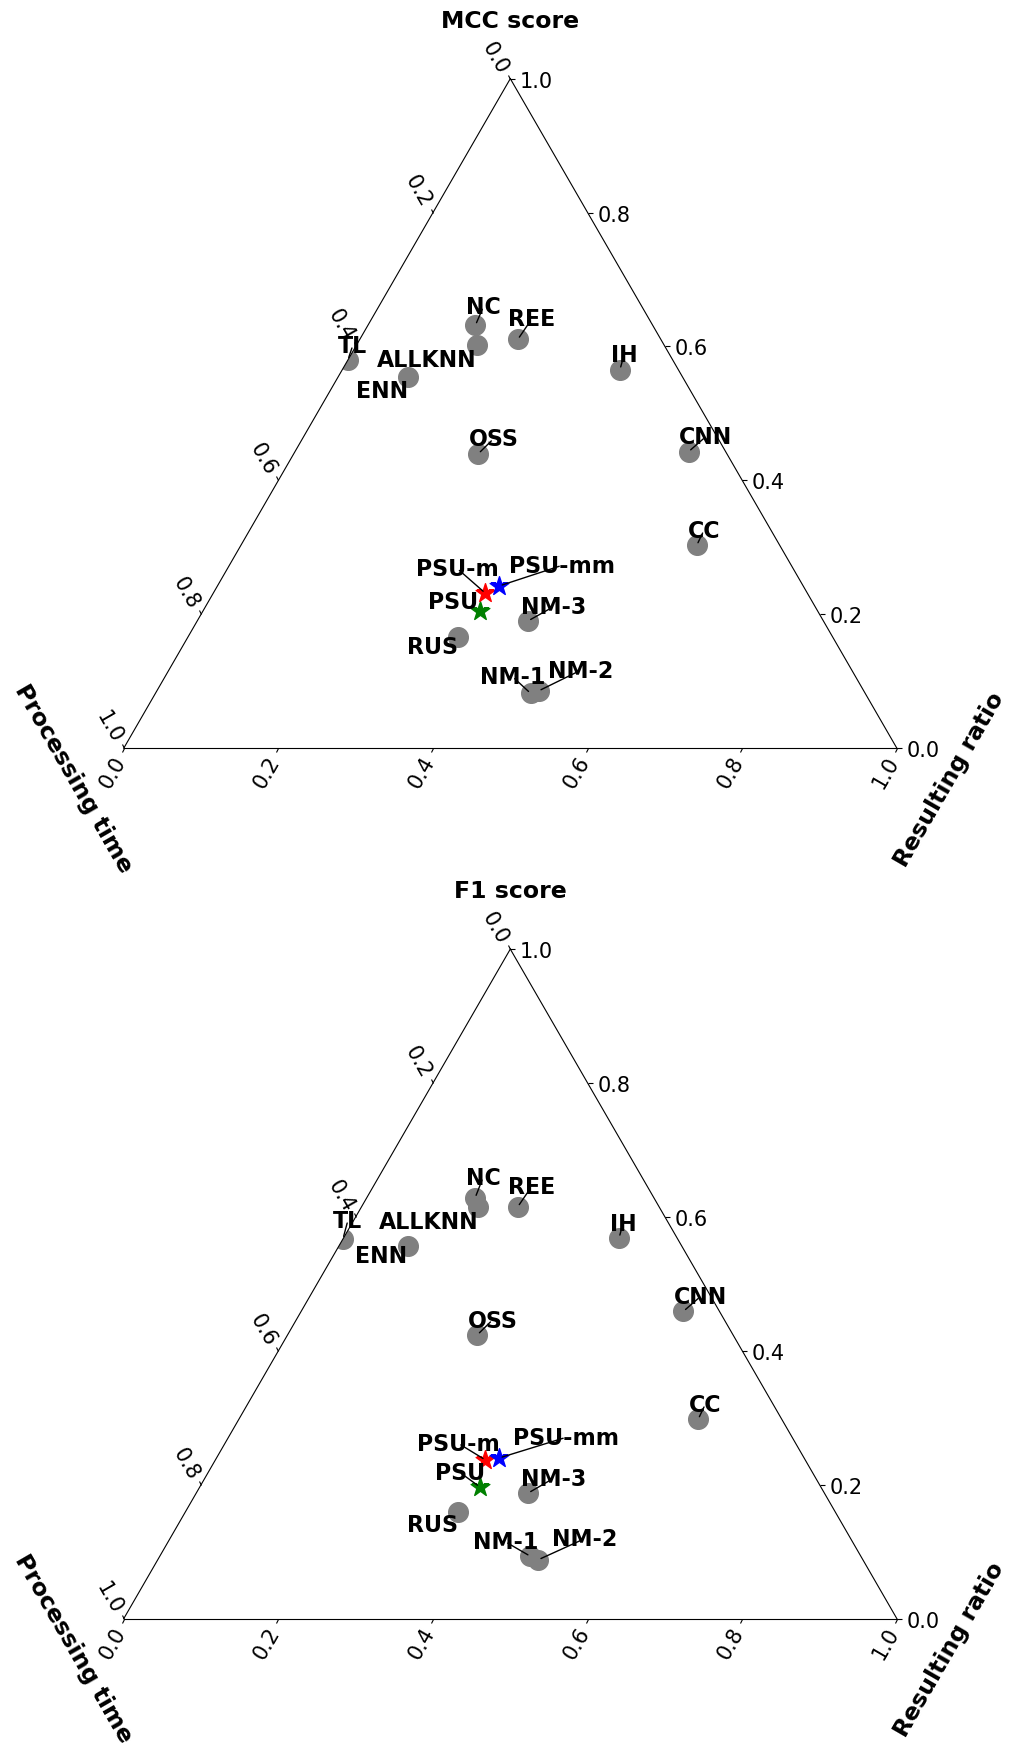

In [9]:
import matplotlib.pyplot as plt
import mpltern
import pandas as pd
import numpy as np
from adjustText import adjust_text  

resulting_ratio_rank = pd.DataFrame(
    np.array(resulting_ratios).reshape(33, 16, 10).mean(axis=2), 
    columns=methods
).rank(ascending=True, axis=1).mean(axis=0)

time_rank = pd.DataFrame(
    np.array(processing_times).reshape(33, 16, 10).mean(axis=2), 
    columns=methods
).rank(ascending=True, axis=1).mean(axis=0)

result_mcc_rank = pd.DataFrame(
    np.array(result_mcc).reshape(33, 16, 10, 4).max(axis=3).mean(axis=2), 
    columns=methods
).rank(ascending=False, axis=1).mean(axis=0)

result_f1_rank = pd.DataFrame(
    np.array(result_f1).reshape(33, 16, 10, 4).max(axis=3).mean(axis=2), 
    columns=methods
).rank(ascending=False, axis=1).mean(axis=0)

max_rank = np.max([resulting_ratio_rank.max(), time_rank.max(), result_mcc_rank.max(), result_f1_rank.max()])

train_ratio_norm = (max_rank - resulting_ratio_rank) / max_rank
time_norm        = (max_rank - time_rank) / max_rank
mcc_norm         = (max_rank - result_mcc_rank) / max_rank
f1_norm          = (max_rank - result_f1_rank) / max_rank

fig, axes = plt.subplots(2, 1, subplot_kw={'projection': 'ternary'}, figsize=(10, 20))

for idx, ax in enumerate(axes):
    texts = []
    for method in methods:
        z = train_ratio_norm[method]
        y = time_norm[method]
        x = mcc_norm[method] if idx == 0 else f1_norm[method]
        if method == "PSU-m":
            color, marker = "red", "*"
        elif method == "PSU-mm":
            color, marker = "blue", "*"
        elif method == "PSU":
            color, marker = "green", "*"
        else:
            color, marker = "gray", "o"
        ax.scatter(x, y, z, c=color, label=method, marker=marker, s=200)
        texts.append(ax.text(x, y, z, method, fontsize=16, fontweight='bold', ha='center'))
    adjust_text(texts, ax=ax, expand_points=(1.2, 1.5), arrowprops=dict(arrowstyle='-', color='black'))
    if idx == 0:
        ax.set_tlabel("MCC score", fontsize=17, fontweight='bold')
    else:
        ax.set_tlabel("F1 score", fontsize=17, fontweight='bold')
    ax.set_llabel("Processing time", fontsize=17, fontweight='bold')
    ax.set_rlabel("Resulting ratio", fontsize=17, fontweight='bold')
    ax.taxis.set_tick_params(labelsize=15)
    ax.laxis.set_tick_params(labelsize=15)
    ax.raxis.set_tick_params(labelsize=15)

plt.subplots_adjust(hspace=0.3)
plt.show()

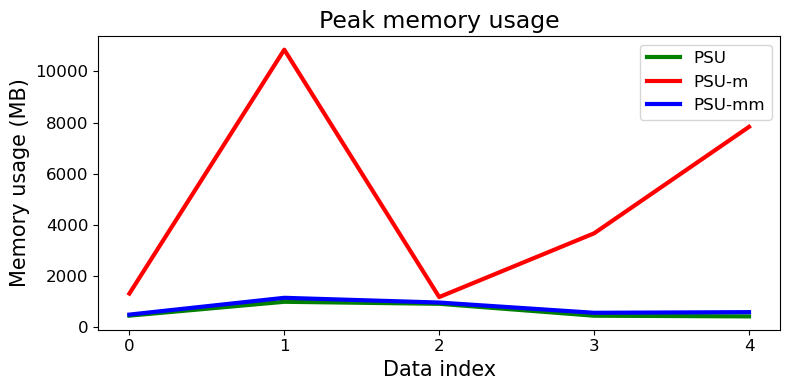

In [10]:
plt.figure(figsize = (8,4))
for i0 in range(3):
    method = methods[i0+4]
    if i0 == 0:
        color = "green"
    if i0 == 1:
        color = "red"
    if i0 == 2:
        color = "blue"
    plt.plot(np.array(memories).reshape(3,5,10).mean(axis = 2)[i0,:], 
             color = color, 
             lw = 3, 
             label = method)
    
plt.xticks(range(5),  fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.title("Peak memory usage", fontsize = 17)
plt.ylabel("Memory usage (MB)", fontsize = 15)
plt.xlabel("Data index", fontsize = 15)
plt.tight_layout()
plt.show()

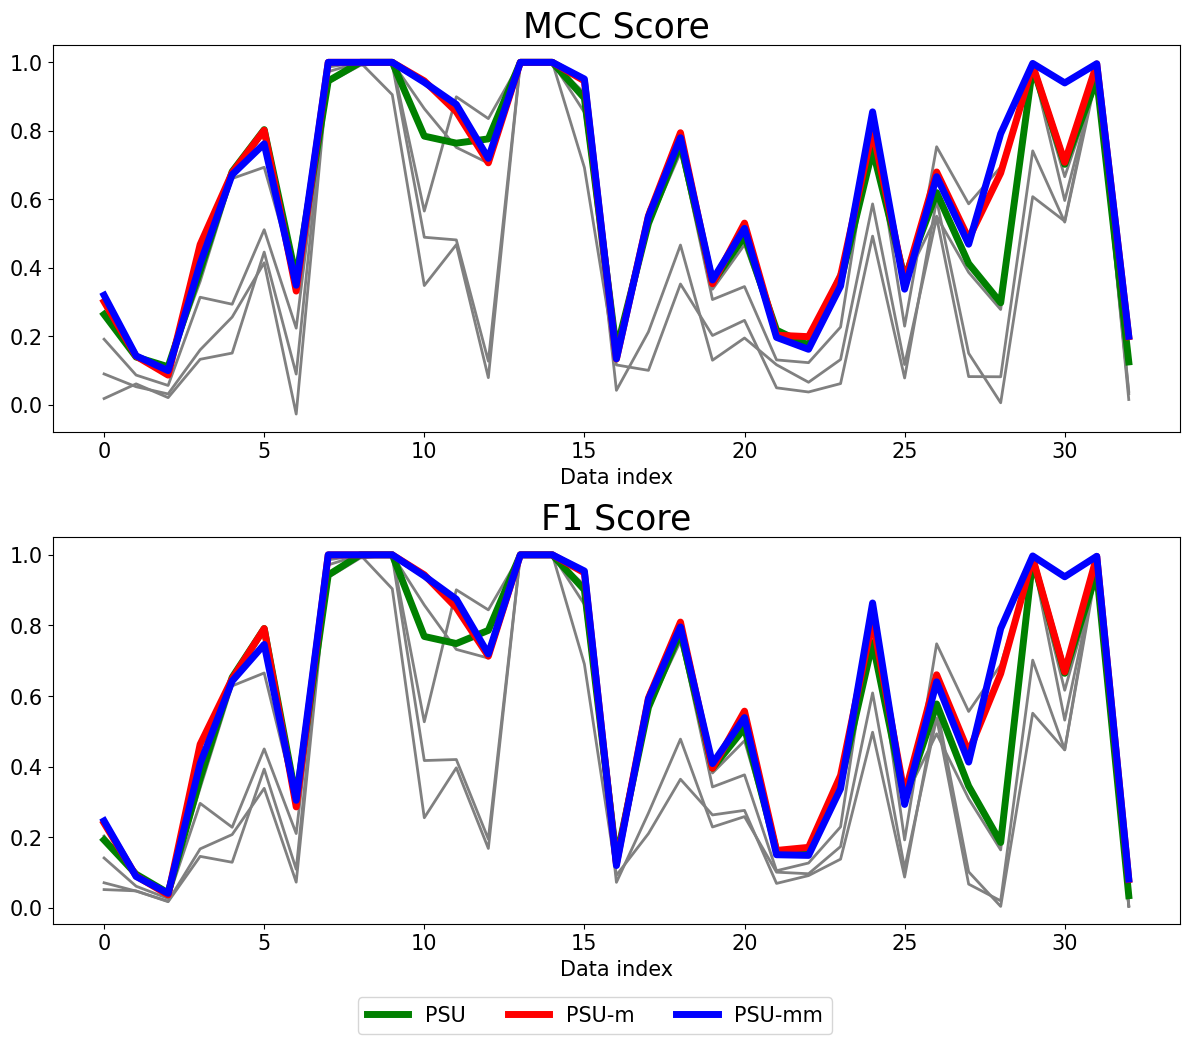

In [11]:
import matplotlib.pyplot as plt
import numpy as np

mcc_data = np.array(result_mcc).reshape(33, 16, 10, 4).max(axis=3).mean(axis=2)
f1_data  = np.array(result_f1).reshape(33, 16, 10, 4).max(axis=3).mean(axis=2)

selected_methods = [0, 1, 2, 3, 4, 5, 6]
colors = {4: "green", 5: "red", 6: "blue"}
default_color = "grey"
datasets = np.arange(33)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
legend_lines, legend_labels = [], []

for method_idx in selected_methods:
    color = colors.get(method_idx, default_color)
    label = methods[method_idx]
    if method_idx in [4, 5, 6]:
        zorder = 10
        line_mcc, = axes[0].plot(datasets, mcc_data[:, method_idx], label=label, color=color, lw=5, zorder=zorder)
        line_f1, = axes[1].plot(datasets, f1_data[:, method_idx], label=label, color=color, lw=5, zorder=zorder)
        legend_lines.append(line_mcc)
        legend_labels.append(label)
    else:
        axes[0].plot(datasets, mcc_data[:, method_idx], color=color, lw=2, zorder=1)
        axes[1].plot(datasets, f1_data[:, method_idx], color=color, lw=2, zorder=1)

axes[0].set_title("MCC Score", fontsize=25)
axes[0].set_xlabel("Data index", fontsize=15)
axes[0].tick_params(axis='both', labelsize=15)

axes[1].set_title("F1 Score", fontsize=25)
axes[1].set_xlabel("Data index", fontsize=15)
axes[1].tick_params(axis='both', labelsize=15)

fig.legend(legend_lines, legend_labels, loc="lower center", ncol=3, fontsize=15, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

In [12]:
result_tpr = []
result_tnr = []
result_fpr = []
result_fnr = []

temp = 0
for i0 in range(33):
    for i1 in range(16):
        for i2 in range(10):
            for i3 in range(4):
                tn, fp, fn, tp = confusion_matrices[temp].ravel()
                
                if tp + fn == 0:
                    tpr = 0
                else:
                    tpr = tp / (tp + fn)
                
                if tn + fp == 0:
                    tnr = 0
                else:
                    tnr = tn / (tn + fp)
                
                if tn + fp == 0:
                    fpr = 0
                else:
                    fpr = fp / (tn + fp)
                
                if tp + fn == 0:
                    fnr = 0
                else:
                    fnr = fn / (tp + fn)
                
                result_tpr.append(tpr)
                result_tnr.append(tnr)
                result_fpr.append(fpr)
                result_fnr.append(fnr)
                
                temp += 1

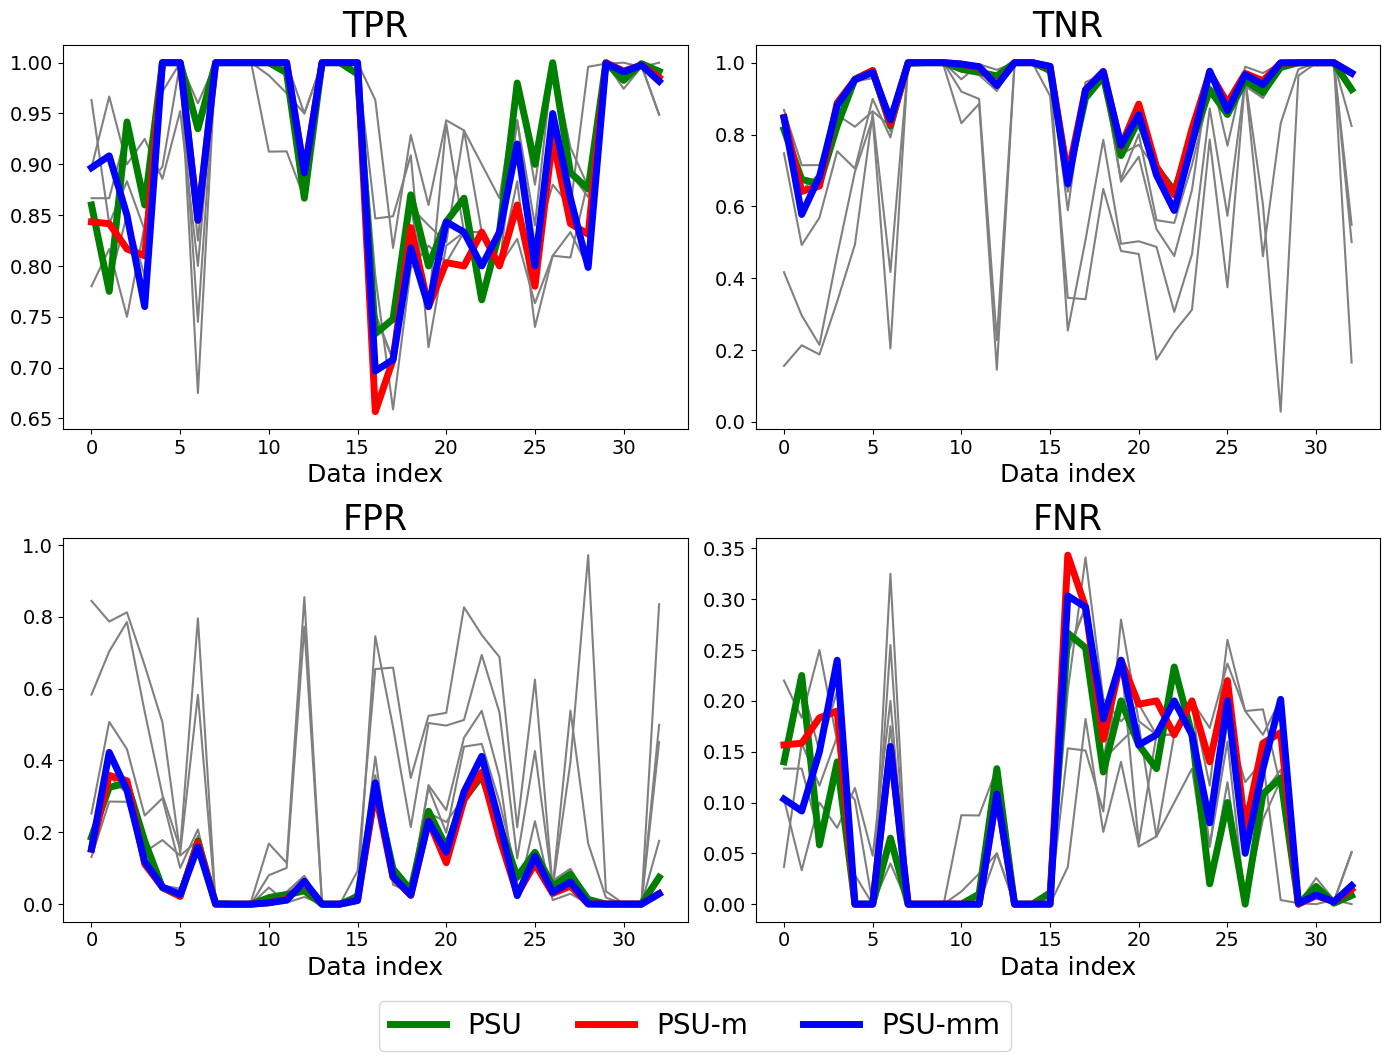

In [13]:
import matplotlib.pyplot as plt
import numpy as np


dim0, dim1, dim2 = np.meshgrid(
    np.arange(33),  
    np.arange(16),  
    np.arange(10),  
    indexing='ij'
)


idx = np.array(result_mcc).reshape(33, 16, 10, 4).argmax(axis=3)

array_tpr = np.array(result_tpr).reshape(33, 16, 10, 4)
tpr_values = array_tpr[dim0, dim1, dim2, idx]

array_tnr = np.array(result_tnr).reshape(33, 16, 10, 4)
tnr_values = array_tnr[dim0, dim1, dim2, idx]

array_fpr = np.array(result_fpr).reshape(33, 16, 10, 4)
fpr_values = array_fpr[dim0, dim1, dim2, idx]

array_fnr = np.array(result_fnr).reshape(33, 16, 10, 4)
fnr_values = array_fnr[dim0, dim1, dim2, idx]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = {
    "TPR": tpr_values,
    "TNR": tnr_values,
    "FPR": fpr_values,
    "FNR": fnr_values
}

colors = {
    "PSU": "green",
    "PSU-m": "red",
    "PSU-mm": "blue",
    "Others": "grey"
}

lws = 5

for ax, (metric_name, values) in zip(axes.flat, metrics.items()):
    for i0 in range(8):  
        if i0 == 4:
            ax.plot(values[:, i0, :].mean(axis=1), label="PSU", color=colors["PSU"], lw=lws, zorder=10)
        elif i0 == 5:
            ax.plot(values[:, i0, :].mean(axis=1), label="PSU-m", color=colors["PSU-m"], lw=lws, zorder=10)
        elif i0 == 6:
            ax.plot(values[:, i0, :].mean(axis=1), label="PSU-mm", color=colors["PSU-mm"], lw=lws, zorder=10)
        else:
            ax.plot(values[:, i0, :].mean(axis=1), color=colors["Others"])
        
        ax.tick_params(axis='x', labelsize=14)  
        ax.tick_params(axis='y', labelsize=14) 

    ax.set_xlabel("Data index", fontsize=18)
    ax.set_title(metric_name, fontsize=25)
        
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=20, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()